<a href="https://colab.research.google.com/github/akritidu/Multi-label-Classification-in-the-Home-Improvement/blob/main/LSTM_Bi_LSTM_GRU_Bi_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, GRU, Bidirectional, GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D, SpatialDropout1D, GlobalMaxPool1D, BatchNormalization
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"/content/drive/MyDrive/Dataset/HMDataset.csv"

'/content/drive/MyDrive/Dataset/HMDataset.csv'

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/HMDataset.csv")

In [ ]:
df.head()

,id,contexts,categories
0,1,!Hi - this junction box was covered with a plu...,"['electrical', 'wiring']"
1,2,"""High efficiency"" & condensing boilers or furn...","['hvac', 'appliances', 'interior-maintenance']"
2,3,"""We moved the microwave to a different spot in...","['electrical', 'wiring']"
3,4,(An update is below the pictures.)We just move...,"['plumbing', 'hvac']"
4,5,(Apologies in advance folks - I'm new to compr...,"['plumbing', 'materials', 'appliances']"


In [ ]:
from ast import literal_eval
df['categories'] = df.categories.apply(lambda x: literal_eval(str(x)))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df.categories)
# Getting a sense of how the tags data looks like
print(y[4])
print(mlb.inverse_transform(y[4].reshape(1,-1)))
print(mlb.classes_)

[1 0 0 0 0 0 0 0 1 1 0 0 0]
[('appliances', 'materials', 'plumbing')]
['appliances' 'electrical' 'exterior-maintenance' 'hardware-tools' 'hvac'
 'insulation' 'interior-maintenance' 'lighting' 'materials' 'plumbing'
 'safety' 'walls-drywallls' 'wiring']


In [ ]:
y.shape[1]

13

In [ ]:
df1 = pd.DataFrame(y, columns = ['appliances', 'electrical', 'exterior-maintenance', 'hardware-tools', 'hvac', 'insulation', 'interior-maintenance', 'lighting', 'materials', 'plumbing', 'safety', 'walls-drywallls', 'wiring'] )
df1.head()

,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
train_df = df.merge(df1, left_index=True, right_index=True)
train_df.head()

,id,contexts,categories,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,1,!Hi - this junction box was covered with a plu...,"[electrical, wiring]",0,1,0,0,0,0,0,0,0,0,0,0,1
1,2,"""High efficiency"" & condensing boilers or furn...","[hvac, appliances, interior-maintenance]",1,0,0,0,1,0,1,0,0,0,0,0,0
2,3,"""We moved the microwave to a different spot in...","[electrical, wiring]",0,1,0,0,0,0,0,0,0,0,0,0,1
3,4,(An update is below the pictures.)We just move...,"[plumbing, hvac]",0,0,0,0,1,0,0,0,0,1,0,0,0
4,5,(Apologies in advance folks - I'm new to compr...,"[plumbing, materials, appliances]",1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
train_df.drop(['categories' , 'id'],axis=1,inplace=True)
train_df.head()

,contexts,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,!Hi - this junction box was covered with a plu...,0,1,0,0,0,0,0,0,0,0,0,0,1
1,"""High efficiency"" & condensing boilers or furn...",1,0,0,0,1,0,1,0,0,0,0,0,0
2,"""We moved the microwave to a different spot in...",0,1,0,0,0,0,0,0,0,0,0,0,1
3,(An update is below the pictures.)We just move...,0,0,0,0,1,0,0,0,0,1,0,0,0
4,(Apologies in advance folks - I'm new to compr...,1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
categories = train_df[['appliances', 'electrical', 'exterior-maintenance','hardware-tools', 'hvac', 'insulation', 'interior-maintenance', 'lighting','materials', 'plumbing', 'safety', 'walls-drywallls', 'wiring']]
categories.head()

,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Lemmatize Words

def fetch_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

#cleaning the data now 

regex = [
    r'<[^>]+>', #HTML tags
    r'@(\w+)', # @-mentions
    r"#(\w+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^0-9a-z #+_\\r\\n\\t]', #BAD SYMBOLS
]

REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
#REPLACE_DIGITS = re.compile(r'\d+')
#REPLACE_BY = re.compile(r"[/(){}\[\]\|,;.:?\-\'\"$]")
REPLACE_BY = re.compile(r"[^a-z0-9\-]")

STOPWORDS = set(stopwords.words('english'))

#tokens_re = re.compile(r'('+'|'.join(regex)+')', re.VERBOSE | re.IGNORECASE)

# sentences = [] #for Word2Vec model

def clean_text(text):
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    text = REPLACE_URLS.sub('', text)
    text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    #text = REPLACE_DIGITS.sub(' ', text)
    text = REPLACE_BY.sub(' ', text)
    
    
    text = " ".join(lemmatizer.lemmatize(word.strip(), fetch_pos_tag(pos_tag([word.strip()])[0][1])) for word in text.split() if word not in STOPWORDS and len(word)>3)
    
    #sentences.append(text.split())
    return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_df['contexts'] = train_df['contexts'].apply(clean_text)

In [ ]:
## for single output layer
X  = train_df['contexts'] 
y = categories.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
"/content/drive/MyDrive/Dataset/glove.6B.100d.txt"

'/content/drive/MyDrive/Dataset/glove.6B.100d.txt'

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros


embeddings_dictionary = dict()

glove_file = open("/content/drive/MyDrive/Dataset/glove.6B.100d.txt")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding( vocab_size , 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(13, activation='sigmoid')(LSTM_Layer_1)
LSTM_glove = Model(inputs=deep_inputs, outputs=dense_layer_1)

LSTM_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()] )

In [ ]:
LSTM_glove.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          2203800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 13)                1677      
                                                                 
Total params: 2,322,725
Trainable params: 118,925
Non-trainable params: 2,203,800
_________________________________________________________________


In [ ]:
history = LSTM_glove.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
107/107 [==============================] - 12s 56ms/step - loss: 0.4198 - auc: 0.5461 - val_loss: 0.3892 - val_auc: 0.5698
Epoch 2/20
107/107 [==============================] - 5s 48ms/step - loss: 0.3901 - auc: 0.5650 - val_loss: 0.3891 - val_auc: 0.5697
Epoch 3/20
107/107 [==============================] - 5s 48ms/step - loss: 0.3902 - auc: 0.5649 - val_loss: 0.3888 - val_auc: 0.5739
Epoch 4/20
107/107 [==============================] - 5s 49ms/step - loss: 0.3900 - auc: 0.5654 - val_loss: 0.3889 - val_auc: 0.5719
Epoch 5/20
107/107 [==============================] - 5s 49ms/step - loss: 0.3897 - auc: 0.5674 - val_loss: 0.3902 - val_auc: 0.5570
Epoch 6/20
107/107 [==============================] - 5s 49ms/step - loss: 0.3899 - auc: 0.5670 - val_loss: 0.3889 - val_auc: 0.5675
Epoch 7/20
107/107 [==============================] - 5s 49ms/step - loss: 0.3894 - auc: 0.5689 - val_loss: 0.3894 - val_auc: 0.5664
Epoch 8/20
107/107 [==============================] - 5s 48ms/step -

In [ ]:
score = LSTM_glove.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

133/133 [==============================] - 2s 18ms/step - loss: 0.2493 - auc: 0.8911
Test Score: 0.2493182271718979
Test Accuracy: 0.8911306858062744


In [ ]:
score = LSTM_glove.evaluate(X_train, y_train, verbose=1)

print("Train Score:", score[0])
print("Train Accuracy:", score[1])

531/531 [==============================] - 10s 18ms/step - loss: 0.2400 - auc: 0.9003
Train Score: 0.240023672580719
Train Accuracy: 0.9003035426139832


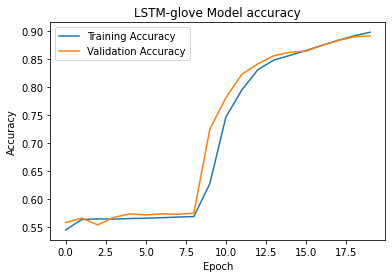

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('LSTM-glove Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.savefig("/content/drive/MyDrive/Dataset/accLS.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

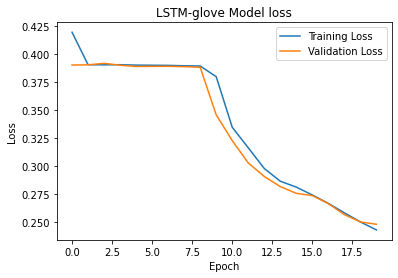

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM-glove Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.savefig("/content/drive/MyDrive/Dataset/lossLS.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

In [ ]:
pred_prob = LSTM_glove.predict_on_batch(X_test)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_NN_01[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions_NN_01.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


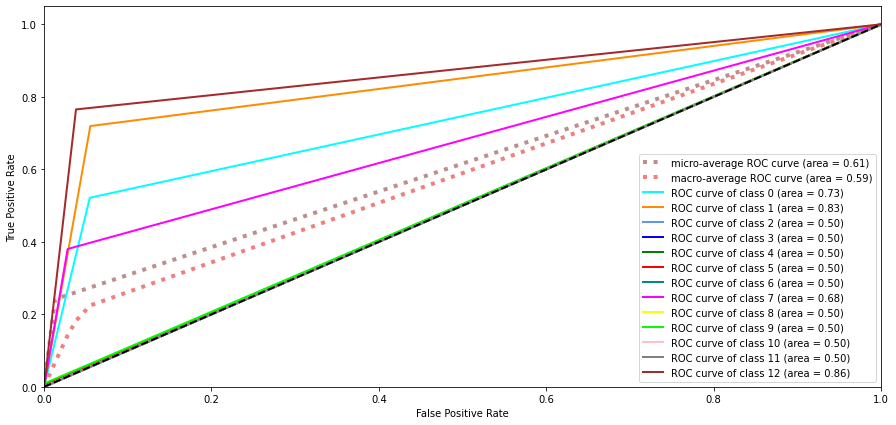

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='rosybrown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='lightcoral', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'darkcyan', 'magenta', 'yellow', 'lime', 'pink', 'gray', 'brown', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.savefig("/content/drive/MyDrive/Dataset/aucroc_LS.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
y_pred = LSTM_glove.predict(X_test)

In [ ]:
from sklearn.metrics import average_precision_score
y_pred = LSTM_glove.predict(X_test)

from sklearn import metrics
from sklearn.metrics import average_precision_score
print("micro: {:.2f}".format(metrics.average_precision_score(y_test, y_pred, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='weighted')))
print("sample: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='samples'))) 

micro: 0.64
macro: 0.59 
weighted: 0.61 
sample: 0.72 


# **BI-LSTM MODEL**

In [ ]:
import tensorflow as tf
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding( vocab_size , 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
model = SpatialDropout1D(0.2)(embedding_layer)
BiLSTM_Layer_1 = Bidirectional(LSTM(128))(model)
dense_layer_1 = Dense(13, activation='sigmoid')(BiLSTM_Layer_1 )
Bi_LSTM_glove = Model(inputs=deep_inputs, outputs=dense_layer_1)
Bi_LSTM_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [ ]:
Bi_LSTM_glove.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          2203800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 13)                3341      
                                                                 
Total params: 2,441,637
Trainable params: 237,837
Non-train

In [ ]:
history_1 = Bi_LSTM_glove.fit(X_train, y_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
54/54 [==============================] - 15s 148ms/step - loss: 0.4111 - auc_1: 0.5889 - val_loss: 0.3505 - val_auc_1: 0.7599
Epoch 2/20
54/54 [==============================] - 7s 126ms/step - loss: 0.3223 - auc_1: 0.7965 - val_loss: 0.3037 - val_auc_1: 0.8273
Epoch 3/20
54/54 [==============================] - 7s 125ms/step - loss: 0.2882 - auc_1: 0.8476 - val_loss: 0.2683 - val_auc_1: 0.8735
Epoch 4/20
54/54 [==============================] - 7s 127ms/step - loss: 0.2665 - auc_1: 0.8748 - val_loss: 0.2455 - val_auc_1: 0.8970
Epoch 5/20
54/54 [==============================] - 7s 126ms/step - loss: 0.2496 - auc_1: 0.8928 - val_loss: 0.2335 - val_auc_1: 0.9072
Epoch 6/20
54/54 [==============================] - 7s 131ms/step - loss: 0.2379 - auc_1: 0.9033 - val_loss: 0.2292 - val_auc_1: 0.9106
Epoch 7/20
54/54 [==============================] - 7s 128ms/step - loss: 0.2312 - auc_1: 0.9096 - val_loss: 0.2217 - val_auc_1: 0.9171
Epoch 8/20
54/54 [=============================

In [ ]:
score = Bi_LSTM_glove.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

133/133 [==============================] - 5s 35ms/step - loss: 0.1944 - auc_2: 0.9376
Test Score: 0.19439317286014557
Test Accuracy: 0.937649130821228


In [ ]:
score = Bi_LSTM_glove.evaluate(X_train, y_train, verbose=1)

print("Train Score:", score[0])
print("Train Accuracy:", score[1])

531/531 [==============================] - 18s 35ms/step - loss: 0.1761 - auc_2: 0.9506
Train Score: 0.17609265446662903
Train Accuracy: 0.9505767822265625


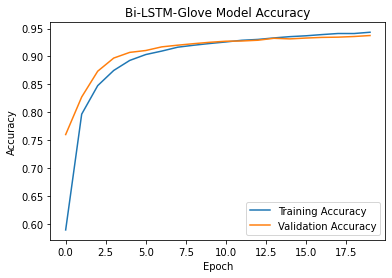

In [ ]:
plt.plot(history_1.history['auc_1'])
plt.plot(history_1.history['val_auc_1'])
plt.title('Bi-LSTM-Glove Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.savefig("/content/drive/MyDrive/Dataset/acc_bi.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()


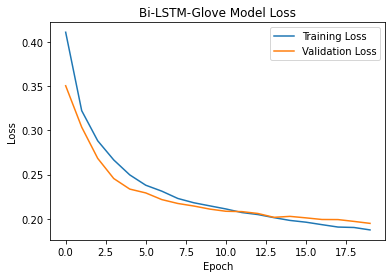

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Bi-LSTM-Glove Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.savefig("/content/drive/MyDrive/Dataset/loss_bi.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()



In [ ]:
pred_prob = Bi_LSTM_glove.predict_on_batch(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


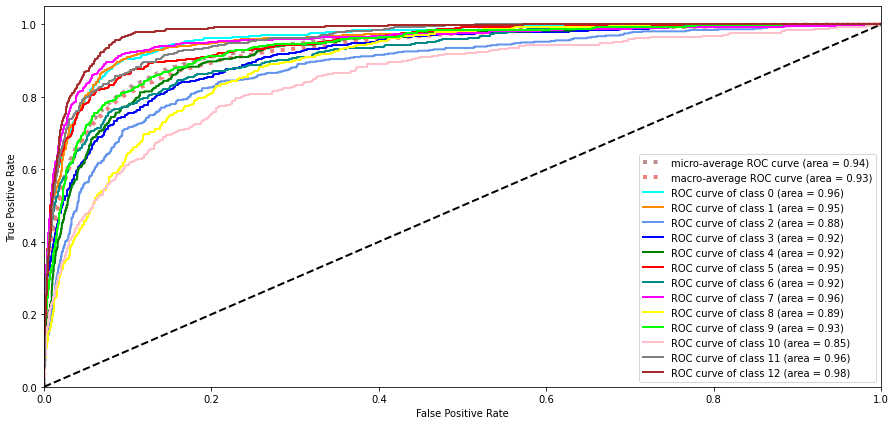

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='rosybrown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='lightcoral', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'darkcyan', 'magenta', 'yellow', 'lime', 'pink', 'gray', 'brown', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.savefig("/content/drive/MyDrive/Dataset/aucroc_bi.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
y_pred = Bi_LSTM_glove.predict(X_test)

In [ ]:
from sklearn.metrics import average_precision_score
y_pred = Bi_LSTM_glove.predict(X_test)

from sklearn import metrics
from sklearn.metrics import average_precision_score
print("micro: {:.2f}".format(metrics.average_precision_score(y_test, y_pred, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='weighted')))
print("sample: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='samples')))  

micro: 0.77
macro: 0.74 
weighted: 0.75 
sample: 0.82 


# **Multiple output layer**

In [ ]:


X  = train_df['contexts'] 
y = train_df[['appliances', 'electrical', 'exterior-maintenance','hardware-tools', 'hvac', 'insulation', 'interior-maintenance', 'lighting','materials', 'plumbing', 'safety', 'walls-drywallls', 'wiring']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:


## Model for multiple dense output layer
# First output
y1_train = y_train[["appliances"]].values
y1_test =  y_test[["appliances"]].values

# Second output
y2_train = y_train[["electrical"]].values
y2_test =  y_test[["electrical"]].values

# Third output
y3_train = y_train[["exterior-maintenance"]].values
y3_test =  y_test[["exterior-maintenance"]].values

# Fourth output
y4_train = y_train[["hardware-tools"]].values
y4_test =  y_test[["hardware-tools"]].values

# Fifth output
y5_train = y_train[["hvac"]].values
y5_test =  y_test[["hvac"]].values

# Sixth output
y6_train = y_train[["insulation"]].values
y6_test =  y_test[["insulation"]].values

# Sixth output
y7_train = y_train[["interior-maintenance"]].values
y7_test =  y_test[["interior-maintenance"]].values

# Sixth output
y8_train = y_train[["lighting"]].values
y8_test =  y_test[["lighting"]].values

# Sixth output
y9_train = y_train[["materials"]].values
y9_test =  y_test[["materials"]].values

# Sixth output
y10_train = y_train[["plumbing"]].values
y10_test =  y_test[["plumbing"]].values

# Sixth output
y11_train = y_train[["safety"]].values
y11_test =  y_test[["safety"]].values

# Sixth output
y12_train = y_train[["walls-drywallls"]].values
y12_test =  y_test[["walls-drywallls"]].values

# Sixth output
y13_train = y_train[["wiring"]].values
y13_test =  y_test[["wiring"]].values


In [ ]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros


embeddings_dictionary = dict()

glove_file = open("/content/drive/MyDrive/Dataset/glove.6B.100d.txt")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf

In [ ]:

input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output7 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output8 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output9 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output10 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output11 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output12 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output13 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6, output7, output8, output9, output10, output11, output12, output13])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train,  y7_train, y8_train,  y9_train,  y10_train,  y11_train,  y12_train,  y13_train], batch_size=8192, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
2/2 [==============================] - 14s 4s/step - loss: 8.9971 - dense_13_loss: 0.6923 - dense_14_loss: 0.6929 - dense_15_loss: 0.6921 - dense_16_loss: 0.6915 - dense_17_loss: 0.6910 - dense_18_loss: 0.6921 - dense_19_loss: 0.6938 - dense_20_loss: 0.6903 - dense_21_loss: 0.6932 - dense_22_loss: 0.6919 - dense_23_loss: 0.6914 - dense_24_loss: 0.6923 - dense_25_loss: 0.6922 - dense_13_auc_1: 0.5004 - dense_14_auc_1: 0.5003 - dense_15_auc_1: 0.4987 - dense_16_auc_1: 0.5013 - dense_17_auc_1: 0.4983 - dense_18_auc_1: 0.4985 - dense_19_auc_1: 0.4981 - dense_20_auc_1: 0.5020 - dense_21_auc_1: 0.4977 - dense_22_auc_1: 0.4955 - dense_23_auc_1: 0.4975 - dense_24_auc_1: 0.4988 - dense_25_auc_1: 0.4961 - val_loss: 8.9479 - val_dense_13_loss: 0.6895 - val_dense_14_loss: 0.6912 - val_dense_15_loss: 0.6870 - val_dense_16_loss: 0.6872 - val_dense_17_loss: 0.6864 - val_dense_18_loss: 0.6882 - val_dense_19_loss: 0.6906 - val_dense_20_loss: 0.6858 - val_dense_21_loss: 0.6894 - val_dense_22_

In [ ]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test, y7_test, y8_test,  y9_test,  y10_test,  y11_test,  y12_test,  y13_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

133/133 [==============================] - 4s 32ms/step - loss: 5.0762 - dense_13_loss: 0.4090 - dense_14_loss: 0.5093 - dense_15_loss: 0.3733 - dense_16_loss: 0.4304 - dense_17_loss: 0.3182 - dense_18_loss: 0.3452 - dense_19_loss: 0.3561 - dense_20_loss: 0.3510 - dense_21_loss: 0.4061 - dense_22_loss: 0.3574 - dense_23_loss: 0.3534 - dense_24_loss: 0.3611 - dense_25_loss: 0.5057 - dense_13_auc_1: 0.4969 - dense_14_auc_1: 0.5046 - dense_15_auc_1: 0.5060 - dense_16_auc_1: 0.5032 - dense_17_auc_1: 0.5048 - dense_18_auc_1: 0.4979 - dense_19_auc_1: 0.5000 - dense_20_auc_1: 0.5039 - dense_21_auc_1: 0.5007 - dense_22_auc_1: 0.4978 - dense_23_auc_1: 0.4988 - dense_24_auc_1: 0.5024 - dense_25_auc_1: 0.5044
Test Score: 5.076234340667725
Test Accuracy: 0.4090240001678467


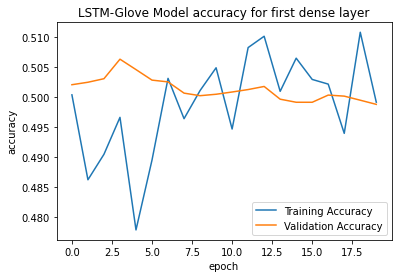

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_13_auc_1'])
plt.plot(history.history['val_dense_13_auc_1'])

plt.title('LSTM-Glove Model accuracy for first dense layer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.savefig("/content/drive/MyDrive/Dataset/acc_1.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()



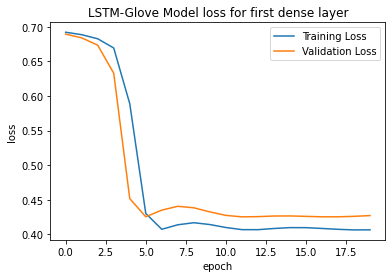

In [ ]:
plt.plot(history.history['dense_13_loss'])
plt.plot(history.history['val_dense_13_loss'])

plt.title('LSTM-Glove Model loss for first dense layer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("/content/drive/MyDrive/Dataset/loss_1.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

# **GRU**

In [ ]:
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D


In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs )
model = SpatialDropout1D(0.2)(embedding_layer)
model = GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)(model)
model = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool])
dense_layer1 = Dense(13, activation="sigmoid")(model)
GRU_glove = Model(deep_inputs , dense_layer1)
GRU_glove.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [ ]:
history_2 = GRU_glove.fit(X_train, y_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
54/54 [==============================] - 65s 984ms/step - loss: 0.3985 - auc: 0.6102 - val_loss: 0.3233 - val_auc: 0.7915
Epoch 2/20
54/54 [==============================] - 53s 985ms/step - loss: 0.3056 - auc: 0.8209 - val_loss: 0.2761 - val_auc: 0.8680
Epoch 3/20
54/54 [==============================] - 53s 986ms/step - loss: 0.2689 - auc: 0.8720 - val_loss: 0.2467 - val_auc: 0.8924
Epoch 4/20
54/54 [==============================] - 53s 976ms/step - loss: 0.2462 - auc: 0.8941 - val_loss: 0.2295 - val_auc: 0.9089
Epoch 5/20
54/54 [==============================] - 54s 994ms/step - loss: 0.2332 - auc: 0.9066 - val_loss: 0.2229 - val_auc: 0.9156
Epoch 6/20
54/54 [==============================] - 53s 977ms/step - loss: 0.2244 - auc: 0.9144 - val_loss: 0.2158 - val_auc: 0.9206
Epoch 7/20
54/54 [==============================] - 53s 985ms/step - loss: 0.2181 - auc: 0.9197 - val_loss: 0.2128 - val_auc: 0.9246
Epoch 8/20
54/54 [==============================] - 52s 964ms/step - 

In [ ]:
score = GRU_glove.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

133/133 [==============================] - 10s 74ms/step - loss: 0.1883 - auc: 0.9434
Test Score: 0.18827736377716064
Test Accuracy: 0.9433537721633911


In [ ]:
score = GRU_glove.evaluate(X_train, y_train, verbose=1)

print("Train Score:", score[0])
print("Train Accuracy:", score[1])

531/531 [==============================] - 40s 75ms/step - loss: 0.1652 - auc: 0.9571
Train Score: 0.16516585648059845
Train Accuracy: 0.9571124315261841


In [ ]:
GRU_glove.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 100)     2203800     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 100)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 gru (GRU)                      (None, 200, 128)     88320       ['spatial_dropout1d[0][0]']  

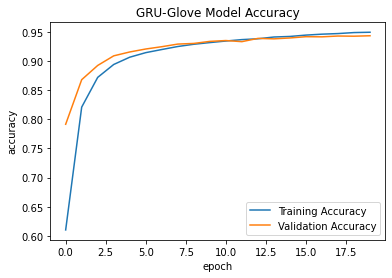

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['auc'])
plt.plot(history_2.history['val_auc'])

plt.title('GRU-Glove Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.savefig("/content/drive/MyDrive/Dataset/acc_gru.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

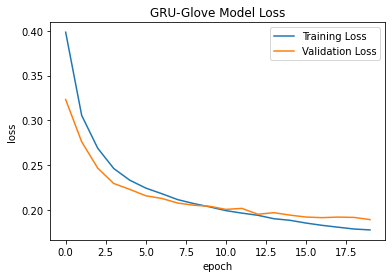

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

plt.title('GRU-Glove Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("/content/drive/MyDrive/Dataset/loss_gru.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

In [ ]:
pred_prob = GRU_glove.predict_on_batch(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score


In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


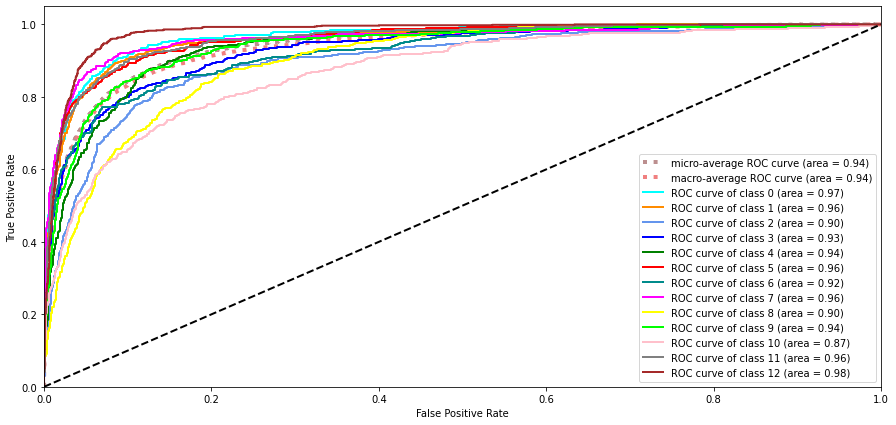

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='rosybrown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='lightcoral', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'darkcyan', 'magenta', 'yellow', 'lime', 'pink', 'gray', 'brown', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.savefig("/content/drive/MyDrive/Dataset/aucroc_gru.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
y_pred = GRU_glove.predict(X_test)

from sklearn import metrics
from sklearn.metrics import average_precision_score
print("micro: {:.2f}".format(metrics.average_precision_score(y_test, y_pred, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='weighted')))
print("sample: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='samples')))  

micro: 0.79
macro: 0.76 
weighted: 0.77 
sample: 0.84 


# **BI-GRU**

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
model = SpatialDropout1D(0.2)(embedding_layer)
model = Bidirectional(GRU(128,return_sequences=True,dropout=0.1,recurrent_dropout=0.1 ))(model)
model = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool])
dense_layer1 = Dense(13, activation="sigmoid")(model)
Bi_GRU_glove = Model(deep_inputs, dense_layer1)
Bi_GRU_glove.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [ ]:
Bi_GRU_glove.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 100)     2203800     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 200, 100)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 256)     176640      ['spatial_dropout1d_1[0][0]

In [ ]:
model = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool])

In [ ]:
history_3 = Bi_GRU_glove.fit(X_train, y_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
54/54 [==============================] - 148s 2s/step - loss: 0.3760 - auc_1: 0.6763 - val_loss: 0.2929 - val_auc_1: 0.8414
Epoch 2/20
54/54 [==============================] - 132s 2s/step - loss: 0.2815 - auc_1: 0.8555 - val_loss: 0.2517 - val_auc_1: 0.8900
Epoch 3/20
54/54 [==============================] - 134s 2s/step - loss: 0.2481 - auc_1: 0.8931 - val_loss: 0.2328 - val_auc_1: 0.9089
Epoch 4/20
54/54 [==============================] - 133s 2s/step - loss: 0.2315 - auc_1: 0.9082 - val_loss: 0.2208 - val_auc_1: 0.9187
Epoch 5/20
54/54 [==============================] - 132s 2s/step - loss: 0.2204 - auc_1: 0.9178 - val_loss: 0.2127 - val_auc_1: 0.9246
Epoch 6/20
54/54 [==============================] - 131s 2s/step - loss: 0.2143 - auc_1: 0.9231 - val_loss: 0.2049 - val_auc_1: 0.9303
Epoch 7/20
54/54 [==============================] - 133s 2s/step - loss: 0.2069 - auc_1: 0.9286 - val_loss: 0.2038 - val_auc_1: 0.9311
Epoch 8/20
54/54 [==============================] - 132

In [ ]:
score = Bi_GRU_glove.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

133/133 [==============================] - 20s 150ms/step - loss: 0.1835 - auc_1: 0.9457
Test Score: 0.1834920346736908
Test Accuracy: 0.9457222819328308


In [ ]:
score = Bi_GRU_glove.evaluate(X_train, y_train, verbose=1)

print("Train Score:", score[0])
print("Train Accuracy:", score[1])

531/531 [==============================] - 81s 152ms/step - loss: 0.1468 - auc_1: 0.9660
Train Score: 0.14677783846855164
Train Accuracy: 0.965984046459198


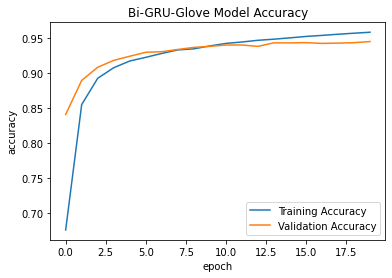

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_3.history['auc_1'])
plt.plot(history_3.history['val_auc_1'])

plt.title('Bi-GRU-Glove Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.savefig("/content/drive/MyDrive/Dataset/bigru.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

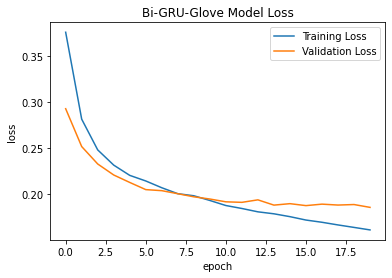

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

plt.title('Bi-GRU-Glove Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("/content/drive/MyDrive/Dataset/loss_bigru.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close()

In [ ]:
pred_prob =  Bi_GRU_glove.predict_on_batch(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


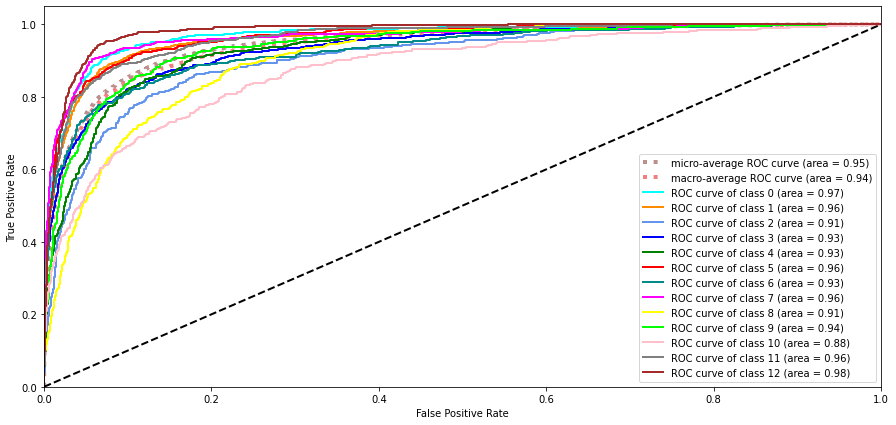

<function matplotlib.pyplot.close>

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='rosybrown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='lightcoral', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'darkcyan', 'magenta', 'yellow', 'lime', 'pink', 'gray', 'brown', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.savefig("/content/drive/MyDrive/Dataset/aucroc_bigru.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly
plt.show()

plt.close

In [ ]:
from sklearn.metrics import average_precision_score
y_pred =  Bi_GRU_glove.predict(X_test)

from sklearn import metrics
from sklearn.metrics import average_precision_score
print("micro: {:.2f}".format(metrics.average_precision_score(y_test, y_pred, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='weighted')))
print("sample: {:.2f} ".format( metrics.average_precision_score(y_test, y_pred, average='samples'))) 

micro: 0.80
macro: 0.77 
weighted: 0.79 
sample: 0.85 
